Please run Evaluation_Fig_3_get_embedding_umap.ipynb first

In [1]:
from tqdm import tqdm
import numpy as np
import faiss
from sklearn import preprocessing
import warnings
import scanpy as sc
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
warnings.filterwarnings("ignore")

from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.extmath import weighted_mode
from sklearn.utils.validation import _num_samples
from sklearn.metrics import classification_report
from sklearn.neighbors._base import _check_weights, _get_weights

In [2]:
class FaissKNeighbors:
    """
    https://towardsdatascience.com/make-knn-300-times-faster-than-scikit-learns-in-20-lines-5e29d74e76bb
    https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09b/sklearn/neighbors/_classification.py#L22
    """
    def __init__(self, k=5, weights='distance'):
        self.index = None
        self.y = None
        self.k = k
        self.le = None
        self.weights = weights

    def fit(self, X, y):
        res = faiss.StandardGpuResources()
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index = faiss.index_cpu_to_gpu(res, 0, self.index)
        self.index.add(X.astype(np.float32))
        self.le = preprocessing.LabelEncoder()
        self.le.fit(y)
        self.y = self.le.transform(y)

    def predict(self, X):
        neigh_dist, neigh_ind = self.index.search(X.astype(np.float32), k=self.k)
        neigh_dist = np.sqrt(neigh_dist)
        
        if self.weights == 'uniform':
            votes = self.y[neigh_ind]
            predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
            return self.le.inverse_transform(predictions)
        
        _y = self.y.reshape((-1, 1))
        classes_ = [self.le.classes_]

        n_outputs = len(classes_)
        n_queries = _num_samples(X)
        weights = _get_weights(neigh_dist, self.weights)

        y_pred = np.empty((n_queries, n_outputs), dtype=classes_[0].dtype)
        for k, classes_k in enumerate(classes_):
            if weights is None:
                mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
            else:
                mode, _ = weighted_mode(_y[neigh_ind, k], weights, axis=1)

            mode = np.asarray(mode.ravel(), dtype=np.intp)
            y_pred[:, k] = classes_k.take(mode)
        y_pred = y_pred.ravel()

        return y_pred


def get_knn_classification(data_atlas, data_query, labels_atlas, labels_query, num_neighbors=5, weights='distance', batch_size=-1, use_faiss=True):
    """
    Evaluates with kNN based on scikit-learn
    :param data_atlas: numpy array (num_cells, hidden_size) embeddings of the atlas data
    :param data_query: numpy array (num_cells, hidden_size) embeddings of the query data
    :param labels_atlas: list (num_cells) labels of the atlas data
    :param labels_query: list (num_cells) labels of the query data
    :param num_neighbors: amount of neighbors used for kNN
    :param weights: kNN weighting,
    :return:
    """

    if use_faiss:
        clf = FaissKNeighbors(num_neighbors, weights)
    else:
        clf = KNeighborsClassifier(num_neighbors, weights)
    
    clf.fit(data_atlas, labels_atlas)
    if batch_size == -1:
        labels_predicted = clf.predict(data_query)
    else:
        labels_predicted = []
        for idx in tqdm(range(data_query.shape[0] // batch_size + 1)):
            labels_predicted.append(clf.predict(data_query[idx*batch_size:(idx+1)*batch_size]))
        labels_predicted = np.concatenate(labels_predicted)
    
    report = classification_report(labels_query, labels_predicted, output_dict=True)
    return report, labels_predicted

def run_knn(adata, weights='distance', k=5, use_faiss=True, metadata=['Tissue', 'Type', 'Tissue+Type', 'functional.cluster', 'Type+functional.cluster', 'Tissue+functional.cluster', 'Cell_type', 'Tissue+Cell_type', 'Type+Cell_type', 'common_clonotypes'], batch_size=-1):
    results = {}
    labels_predicted = {}
    data_atlas = adata[(adata.obs['set'] == 'train') & (adata.obs['functional.cluster'] != 'nan')].X
    data_query = adata[(adata.obs['set'] == 'hold_out') & (adata.obs['functional.cluster'] != 'nan')].X

    for label in tqdm(metadata, 'metadata'):
        labels_atlas = adata[(adata.obs['set'] == 'train') & (adata.obs['functional.cluster'] != 'nan')].obs[label].to_list()
        labels_query = adata[(adata.obs['set'] == 'hold_out') & (adata.obs['functional.cluster'] != 'nan')].obs[label].to_list()

        report, labels_predicted_ = get_knn_classification(data_atlas, data_query[:], labels_atlas, labels_query[:], num_neighbors=k, batch_size=-1, weights=weights, use_faiss=use_faiss)
        results[label] = report['weighted avg']['f1-score']
        labels_predicted[label] = labels_predicted_
    return results, labels_predicted

In [3]:
latent_with = sc.read_h5ad(f'../data/borcherding_moe_scarches.h5ad')
latent_without = sc.read_h5ad(f'../data/borcherding_moe_baseline.h5ad')

adatas = {'MoE w/ scArches': latent_with, 'MoE w/o scArches': latent_without}

In [4]:
all_results = defaultdict(list)
for method in ['MoE w/ scArches', 'MoE w/o scArches']:
    for k in [1, 3, 5, 10, 30, 50, 100, 300, 500, 1000]:
        result, labels_predicted = run_knn(adatas[method], weights='distance', use_faiss=True, k=k, metadata=['Tissue', 'Type', 'functional.cluster'])
        all_results['Method'].extend([method] * len(result))
        all_results['Label'].extend(result.keys())
        all_results['Value'].extend(result.values())
        all_results['k'].extend([k] * len(result))

metadata: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.46s/it]


In [5]:
all_results = pd.DataFrame(all_results)
all_results

,Method,Label,Value,k
0,MoE w/ scArches,Tissue,0.937940,1
1,MoE w/ scArches,Type,0.669775,1
2,MoE w/ scArches,functional.cluster,0.449592,1
3,MoE w/ scArches,Tissue,0.955372,3
4,MoE w/ scArches,Type,0.715293,3
5,MoE w/ scArches,functional.cluster,0.475694,3
6,MoE w/ scArches,Tissue,0.961500,5
7,MoE w/ scArches,Type,0.738419,5
8,MoE w/ scArches,functional.cluster,0.496010,5
9,MoE w/ scArches,Tissue,0.967489,10


In [6]:
os.makedirs('../results', exist_ok=True)
all_results.to_csv('../results/kNN.csv')

In [7]:
all_results['Label'] = all_results['Label'].map({'Tissue': 'Cancer', 'Type': 'Tissue', 'functional.cluster': 'Cell Type'})

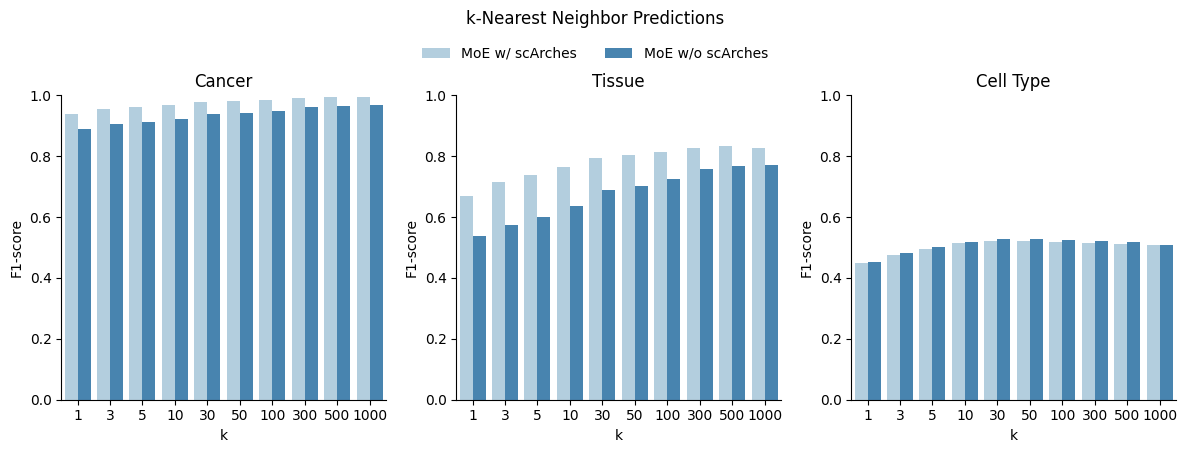

In [8]:
plt.figure(figsize=(12, 4))
for i, label in enumerate(['Cancer', 'Tissue', 'Cell Type']):
    plt.subplot(1, 3, i+1)
    ax = sns.barplot(all_results[all_results['Label'] == label], hue='Method', y='Value', x='k', palette='Blues')
    plt.legend([], [], frameon=False)
    plt.ylabel('F1-score')
    plt.title(label)
    plt.ylim([0, 1])
    ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.06), frameon=False)
plt.tight_layout()
plt.suptitle('k-Nearest Neighbor Predictions', y=1.12)
plt.savefig('figures/kNN_barplot.png', bbox_inches='tight')
plt.show()

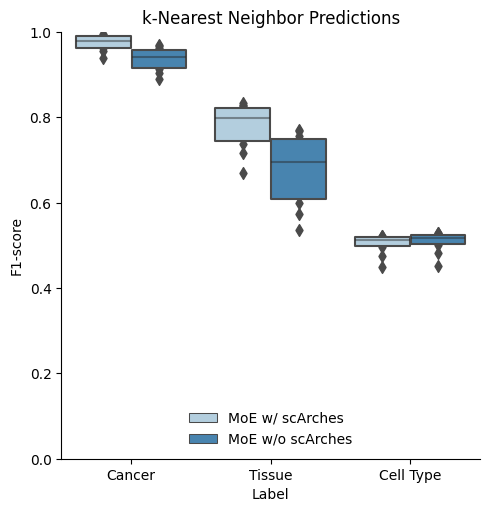

In [9]:
sns.catplot(all_results, hue='Method', y='Value', x='Label', kind='boxen', legend_out=False, palette='Blues')
plt.title('k-Nearest Neighbor Predictions')
plt.legend(loc='lower center', frameon=False)
plt.ylabel('F1-score')
plt.ylim(0, 1)
plt.savefig('figures/kNN_boxenplot.png', bbox_inches='tight')
plt.show()